# Machine Problem 3: NumPy CNN

### Import Libraries

In [1]:
import numpy as np
import os
import time
from scipy import signal
from imageio import imread
from random import shuffle
from matplotlib import pyplot as plt
from tqdm import tqdm

%matplotlib inline

### Preprocessing Functions

In [2]:
# load_images
    # Read in images and makes a list for each set in the form: [images, labels]
    # images: np array with dims [N x img_height x img width x num_channels]
    # labels: np array with dims [N x 1]. elephant = 0, lionfish = 1
    #
    # Returns:  train_set: The list [train_images, train_labels]
    #           val_set: The list [val_images, val_labels] 

def load_images():
    
    sets = ['train', 'val']
    
    data_sets = []
    for dset in sets:
        img_path = './bin_dataset/' + dset + '/ele'
        ele_list = [imread(os.path.join(img_path, img)) for img in os.listdir(img_path)]

        img_path = './bin_dataset/' + dset + '/lio'
        lio_list = [imread(os.path.join(img_path, img)) for img in os.listdir(img_path)]

        set_images = np.stack(ele_list + lio_list)
        N = set_images.shape[0]
        labels = np.ones((N,1))
        labels[0:int(N/2)] = 0
        data_sets.append([set_images, labels])

    train_set, val_set = data_sets

    print("Loaded", len(train_set[0]), "training images")
    print("Loaded", len(val_set[0]), "validation images")
    
    #to normalize all the training set and val set
    train_set[0] = train_set[0]/255
    val_set[0] = val_set[0]/255
    
    return train_set, val_set




# batchify
#     Inputs:    train_set: List containing images and labels
#                batch size: The desired size of each batch
    
#     Returns:   image_batches: A list of shuffled training image batches, each with size batch_size
#                label_batches: A list of shuffled training label batches, each with size batch_size 

def batchify(train_set, batch_size):
    
    index = np.random.permutation(2000)
    train_set[0], train_set[1] = train_set[0][index], train_set[1][index]

    
    image_batches = []
    label_batches = []
    
    
    for i in range(0, len(train_set[0]), batch_size):
            image_batches.append(train_set[0][i:i+batch_size])            
            label_batches.append(train_set[1][i:i+batch_size])

   

    return image_batches, label_batches


### Network Functions

#### Activation Functions

In [3]:
# relu
    # Inputs:   x: Multi-dimensional array with size N along the first axis
    # 
    # Returns:  out: Multi-dimensional array with same size of x 

def relu(x):
    
    out = np.maximum(0,x)
    
    return out


# sigmoid
    # Inputs:    x: Multi-dimensional array with size N along the first axis
    # 
    # Returns:   out: Multi-dimensional array with same size of x 

def sigmoid(x):
    

    out = 1 / (1 + np.exp(-x))
    
    return out


# unit_step
    # Inputs:    x: Multi-dimensional array with size N along the first axis 
    # 
    # Returns:   out: Multi-dimensional array with same size of x 

def unit_step(x):
    
    out=x>0
   
    
    return out 

#### Layer Functions

In [4]:
# convolve2D
    # Inputs:    X: [N x height x width x num_channels]
    #            filters: [num_filters x filter_height x filter_width x num_input_channels]
    # 
    # Returns:   Xc: output array by convoling X and filters. [N x output_height x output_width x num_filters]

def convolve2D(X0, filters):
   
    N, X0_len, _, num_ch = X0.shape
    num_out_ch, filter_len, _, _ = filters.shape
    F0_side = X0_len - filter_len + 1
    
    F0 = np.zeros((N, F0_side, F0_side, num_out_ch))
    temp  = np.zeros((1,5,5,1))
    
    for n in range(N):
        for o_ch in range(num_out_ch):
            for ch in range(num_ch):
                
                F0[n,:,:,o_ch] += signal.convolve2d(X0[n,:,:,ch],filters[o_ch,:,:,ch],mode='valid')
                
                
#                 for f0_row in range(F0_side):
#                     for f0_col in range(F0_side):
#                         temp = X0[n,(0+f0_row):(filter_len+f0_row),(0+f0_col):(filter_len+f0_col),ch]*filters[o_ch,:,:,ch]
                        
#                         F0[n,f0_row,f0_col,o_ch] = sum(sum(temp))
    return F0


# maxPool
    # Inputs:    R0: [N x height x width x num_channels]
    #            mp_len: size of max pool window, also the stride for this MP
    # 
    # Returns:   p_out: output of pooling R0. [N x output_height x output_width x num_channels]
    #            R0_mask: A binary mask with the same size as R0. Indicates which index was chosen to be the max
    #            for each max pool window. This will be used for backpropagation.

def maxPool(R0, mp_len):

    N, R0_len, _, num_ch = R0.shape
    p_out_len = int((R0_len-mp_len)/mp_len + 1)

    R0_mask = np.zeros(R0.shape)
    p_out = np.zeros((N, p_out_len, p_out_len, num_ch))
    
    for n in range(N):
        for ch in range(num_ch):
            for row in range(p_out_len): 
                for col in range(p_out_len):
                    
                    
                    p_out[n,row,col,ch] = np.max(R0[n, row*mp_len:(row+1)*mp_len, col*mp_len:(col+1)*mp_len ,ch])
                    
                    
                    index_row = int(np.argmax(R0[n, row*mp_len:(row+1)*mp_len, col*mp_len:(col+1)*mp_len ,ch])/mp_len)
                    index_col = np.argmax(R0[n, row*mp_len:(row+1)*mp_len, col*mp_len:(col+1)*mp_len ,ch])%mp_len
                    R0_mask[n, row*mp_len+index_row, col*mp_len+index_col,ch] = 1
                    
                    
#                     pool = R0[n,(row*mp_len):((row+1)*mp_len),(col*mp_len):((col+1)*mp_len),ch]
                    
#                     p_out[n,row,col,ch] = pool.max()
                    
                    
#                     ind_max = np.where(pool == pool.max()) 
                    
#                     I0 = ind_max[0]
#                     I1 = ind_max[1]
                        
                    
#                     R0_mask[n,I0[0],I1[0],ch] = 1

    
    return p_out, R0_mask


# fc
    # Inputs:    X: [N x num_input_features]
    #            W: [num_input_features x num_fc_nodes]
    # 
    # Returns:   out: Linear combination of X and W. [N x num_fc_nodes]

def fc(X, W):
     
    out = np.dot(X,W)
    
    return out

In [5]:
a =np.zeros((4,5,2,3))
# print(a)

a[1,2,1,2] =10

ind_max = np.where(a == a.max())

# print(ind_max)
I0 = ind_max[0]
I1 = ind_max[1]
I2 = ind_max[2]
I3 = ind_max[3] 

# print(a[I0[0],I1[0],I2[0],I3[0]] )



# print(I0[0])
# print(I1[0])
# print(I2[0])
# print(I3[0])


#### CNN Functions

In [6]:
# cnn_fwd
    # Inputs:    X0: batch of images. [N x img_height x img_width x num_channels]
    #            W0, W1, W2: Parameters of the CNN
    #            mp_len: the length of one side of the max pool window
    # 
    # Returns:   sig: vector containing the output for each sample. [N x 1]
    #            cache: a dict containing the relevant output layer calculations that will be
    #            used in backpropagation
    
def cnn_fwd(X0, W0, W1, W2, mp_len):
    
    # F0 
    F0 = convolve2D(X0,W0);
    R0 = relu(F0)
    

    # X1p 
    
    X1p,R0_mask = maxPool(R0,mp_len)
    
    # X1 (flatten)
    
    #X1 = X1p.flatten()

    X1 = X1p.reshape((X1p.shape[0],X1p.shape[1]*X1p.shape[2]*X1p.shape[3]))
    
    # FC Layers

    F1 = fc(X1,W1)
    X2 = relu(F1)
    F2 = fc(X2,W2)
    
    
    
    # Output
    sig  = sigmoid(F2)
    
    # Save outputs of functions for backward pass
    cache = {
        "F0":F0,
        "R0":R0,
        "X1p":X1p,
        "R0m":R0_mask,
        "X1":X1,
        "F1":F1,
        "X2":X2,
        "F2":F2      
    }
    
    return sig, cache


# loss
    # Inputs:    sig: vector containing the CNN output for each sample. [N x 1]
    #            Y: vector containing the ground truth label for each sample. [N x 1]
    # 
    # Returns:   L: Loss/error criterion for the model. 

def loss(sig, Y):
    
    L = 0
    
    for i in range(len(Y)):
        
        L += -np.dot(Y[i],np.log(sig[i])) - np.dot((1-Y[i]),np.log(1-sig[i]))
      
    L = L/len(Y)
 
    
    
    return L


### Backprop Functions

In [7]:
# convolve2DBwd
    # Inputs:    X0: batch of images. [N x height x width x num_channels]
    #            dL_dF0: Gradient at the output of the conv layer. 
    # 
    # Returns:   dL_dW0. gradient of loss L wrt W0. Same size as W0

def convolve2DBwd(X0, dL_dF0):
    
    N, X0_len, _, num_ch = X0.shape
    _, dL_dF0_len, _, num_out_ch  = dL_dF0.shape
    filter_len = X0_len - dL_dF0_len + 1
    
    dL_dW0 = np.zeros((num_out_ch, filter_len, filter_len, num_ch))
    
    for n in range(N):
        for o_ch in range(num_out_ch):
            for ch in range(num_ch):
                dL_dW0[o_ch,:,:,ch] += signal.convolve2d(np.flip(np.flip(X0[n,:,:,ch],0),1),dL_dF0[n,:,:,ch],mode='valid')
    
    return dL_dW0


# maxPoolBwd
    # Inputs:    dL_dX1p: Gradient at the output of the MaxPool layer
    #            R0_mask: A binary mask with the same size as R0. Defined in maxPool
    #            mp_len: the length of one side of the max pool window
    # 
    # Returns:   dL_dR0: Gradient at the output of ReLu
    
def maxPoolBwd(dL_dX1p, R0_mask,  mp_len):
    
    N, H, W, C = R0_mask.shape
    N, dH, dW, C = dL_dX1p.shape
    
    dL_dR0 = np.zeros(R0_mask.shape)
    
    for n in range(N):
        for ch in range(C):
            for row in range(dH):
                for col in range(dW):

                    dL_dR0[n, row*mp_len:(row+1)*mp_len, col*mp_len:(col+1)*mp_len, ch] =\
                    R0_mask[n, row*mp_len:(row+1)*mp_len, col*mp_len:(col+1)*mp_len, ch] * dL_dX1p[n, row, col, ch]
                    
    return dL_dR0


# dL_dW2
    # Inputs:    Y: vector containing the ground truth label for each sample. [N x 1]
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW2: Gradient of the Loss wrt W2
    
def dL_dW2(Y, cache):
   
    dL_dW2 = np.zeros((2,1))
    
    F2 = cache['F2']
    X2 = cache['X2']
    

    dL_dW2 = np.dot(X2.transpose(),(sigmoid(F2)-Y))
    
    dL_dW2 = dL_dW2/len(Y)
    
    return dL_dW2


# dL_dW1
    # Inputs:    Y: vector containing the ground truth label for each sample. [N x 1]
    #            W2: Weight matrix for the second FC layer
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW1: Gradient of the Loss wrt W1
    
def dL_dW1(Y, W2, cache):

    
    
    F2 = cache['F2']
    F1 = cache['F1']
    X1 = cache['X1']
    
    
    dL_dF2 = np.dot((sigmoid(F2)-Y),W2.transpose())
    
    dL_dF1= dL_dF2*unit_step(F1)
    
    dL_dW1 = np.dot(X1.transpose(),dL_dF1)
 
    dL_dW1 = dL_dW1/len(Y)
    

    
 
    return dL_dW1


# dL_dW0
    # Inputs:    X0: batch of images. [N x height x width x num_channels]
    #            Y: vector containing the ground truth label for each sample. [N x 1]
    #            W1: Weight matrix for the first FC layer
    #            W2: Weight matrix for the second FC layer
    #            mp_len: the length of one side of the max pool window
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW0: Gradient of the Loss wrt W0

def dL_dW0(X0, Y, W1, W2, mp_len, cache):
    
    N, X1p_len, _, no_out_ch  = cache['X1p'].shape
    F2 = cache['F2']
    F1 = cache['F1']
    R0m = cache['R0m']
    F0 = cache['F0']
    
    #dL_dF2
    dL_dF2=np.dot((sigmoid(F2)-Y),W2.transpose())
    
    #dL_dF1
    dL_dF1=dL_dF2*unit_step(F1)
    
    #dL_dX1
    dL_dX1=np.dot(dL_dF1,W1.transpose())
    
    # dL_dX1p (unflatten)
    dL_dX1p = dL_dX1.reshape((N, X1p_len,X1p_len,no_out_ch))
    
    # dL_dR0 (unpool)
    
    dL_dR0 = maxPoolBwd(dL_dX1p, R0m,  mp_len)
    
    # dL_dF0 (relu_bwd)
    
    dL_dF0 = dL_dR0*unit_step(F0)
    
    # dL_dW0
    dL_dW0 = convolve2DBwd(X0, dL_dF0)
    
    dL_dW0 = dL_dW0 /len(Y)
    
    return dL_dW0
    
        

### Training

#### Load Images

In [8]:
train_set, val_set = load_images()


Loaded 2000 training images
Loaded 800 validation images


#### Config

In [11]:
# Hyperparameters
epochs = 20
lr = 0.1
batch_size = 16
filter_len = 5
num_out_ch = 3
mp_len = 12
fc_nodes = 2

# Declare weights
W0 = np.random.randn(num_out_ch, filter_len, filter_len, 3) * 0.05
W1 = np.random.randn(192, fc_nodes) * 0.05
W2 = np.random.randn(fc_nodes,1) * 0.05


In [12]:
for i in tqdm(range(epochs)):
    
    image_batches, label_batches = batchify(train_set, batch_size)
    
    num_batches = int(2000/16)
    
    
    for b_idx in range(num_batches):
        X = image_batches[b_idx]
        Y = label_batches[b_idx]
        
        sig, cache = cnn_fwd(X, W0, W1, W2, mp_len)
        
        
        # Calculate gradients
        a = dL_dW2(Y, cache)
        b = dL_dW1(Y,W2, cache)
        c = dL_dW0(X, Y, W1, W2, mp_len, cache)

        
        # Update gradients
        W2 = W2 - lr*a
        W1 = W1 - lr*b
        W0 = W0 - lr*c
        
    sig, _ = cnn_fwd(val_set[0], W0, W1, W2, mp_len)
    train_acc = len(np.where(np.round(sig) == val_set[1])[0])/len(val_set[1])

    print("train_loss:", loss(sig, val_set[1]), "train_acc:", train_acc)
        
        
      


  5%|▌         | 1/20 [00:44<14:00, 44.23s/it]

train_loss: 0.6926652196195842 train_acc: 0.555



 10%|█         | 2/20 [01:28<13:16, 44.23s/it]

train_loss: 0.687897668973534 train_acc: 0.50375



 15%|█▌        | 3/20 [02:12<12:31, 44.23s/it]

train_loss: 0.6209312639762584 train_acc: 0.525



 20%|██        | 4/20 [02:56<11:47, 44.19s/it]

train_loss: 0.3769718218737015 train_acc: 0.84



 25%|██▌       | 5/20 [03:42<11:09, 44.64s/it]

train_loss: 0.4178679678253733 train_acc: 0.8275



 30%|███       | 6/20 [04:27<10:27, 44.85s/it]

train_loss: 0.4244412934079428 train_acc: 0.815



 35%|███▌      | 7/20 [05:13<09:44, 44.95s/it]

train_loss: 0.42492060601707066 train_acc: 0.795



 40%|████      | 8/20 [05:57<08:58, 44.86s/it]

train_loss: 0.47037011537317547 train_acc: 0.81375



 45%|████▌     | 9/20 [06:42<08:14, 44.96s/it]

train_loss: 0.4049123535103762 train_acc: 0.8275



 50%|█████     | 10/20 [07:28<07:31, 45.18s/it]

train_loss: 0.5212996276308416 train_acc: 0.8275



 55%|█████▌    | 11/20 [08:14<06:48, 45.36s/it]

train_loss: 0.5945359879074495 train_acc: 0.49625



 60%|██████    | 12/20 [08:59<06:03, 45.38s/it]

train_loss: 0.46011598966170225 train_acc: 0.8



 65%|██████▌   | 13/20 [09:45<05:18, 45.46s/it]

train_loss: 0.46534811115822405 train_acc: 0.77625



 70%|███████   | 14/20 [10:31<04:34, 45.72s/it]

train_loss: 0.5422562396533174 train_acc: 0.805



 75%|███████▌  | 15/20 [11:16<03:47, 45.53s/it]

train_loss: 0.5205526390731702 train_acc: 0.625



 80%|████████  | 16/20 [12:02<03:02, 45.65s/it]

train_loss: 0.5714778083700723 train_acc: 0.7575



 85%|████████▌ | 17/20 [12:48<02:17, 45.76s/it]

train_loss: 0.5695530419322631 train_acc: 0.79375



 90%|█████████ | 18/20 [13:34<01:31, 45.83s/it]

train_loss: 0.5655991810447497 train_acc: 0.76875



 95%|█████████▌| 19/20 [14:19<00:45, 45.60s/it]

train_loss: 0.5641116147713254 train_acc: 0.80375



100%|██████████| 20/20 [15:06<00:00, 45.86s/it]


train_loss: 0.5873807750061064 train_acc: 0.75125


### Test Correctness of Forward and Backward Pass

#### Forward

In [14]:
weights = np.load('weights.npz')
W0 = weights['W0']
W1 = weights['W1']
W2 = weights['W2']

sig, cache = cnn_fwd(val_set[0], W0, W1, W2, mp_len)
train_acc = len(np.where(np.round(sig) == val_set[1])[0])/len(val_set[1])

print("train_loss:", loss(sig, val_set[1]), "train_acc:", train_acc)

print(W0.shape)
print(W1.shape)
print(W2.shape)


train_loss: 0.23271396293817287 train_acc: 0.9175
(3, 5, 5, 3)
(192, 2)
(2, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(800, 96, 96, 3)
(3, 5, 5, 3)


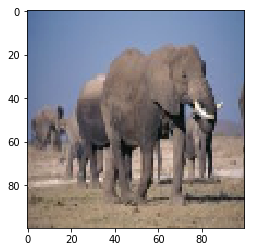

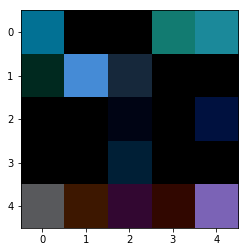

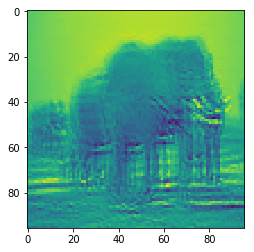

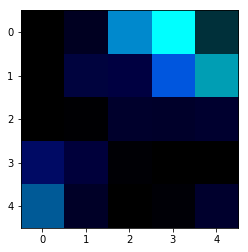

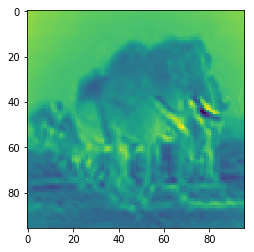

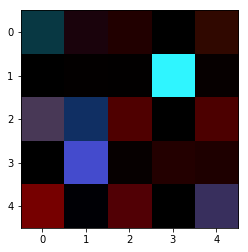

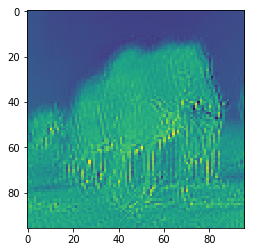

In [15]:
result = cache['F0']
img_num = 334



print(result.shape)
print(W0.shape)

plt.figure(1)
plt.imshow(val_set[0][img_num])


plt.figure(2)
plt.imshow(W0[0])

plt.figure(3)
plt.imshow(result[img_num, :, :, 0])

plt.figure(4)
plt.imshow(W0[1])

plt.figure(5)
plt.imshow(result[img_num, :, :, 1])

plt.figure(6)
plt.imshow(W0[2])

plt.figure(7)
plt.imshow(result[img_num, :, :, 2])




In [71]:
from sklearn.metrics import confusion_matrix


real = [float(i) for i in val_set[1]]

sig_list = sig.tolist()

preds = [1 if j[0]>0.5 else 0 for j in sig_list]



confusion_matrix(real, preds)/400


array([[0.94 , 0.06 ],
       [0.105, 0.895]])

#### Backward

In [ ]:
# Make backprop testing batch
X_bp = np.vstack([train_set[0][0:8,:,:,:], train_set[0][-9:-1,:,:,:]])
Y_bp = np.vstack([train_set[1][0:8], train_set[1][-9:-1]])

# Initialize weights to all ones
W0=np.ones((3, 5, 5, 3))
W1=np.ones((192, 2))
W2=np.ones((2, 1))

sig, cache = cnn_fwd(X_bp, W0, W1, W2, mp_len)


# Update weights once
a = dL_dW2(Y_bp, cache)
b = dL_dW1(Y_bp,W2, cache)
c = dL_dW0(X_bp, Y_bp, W1, W2, mp_len, cache)

W2 = W2 - lr*a
W1 = W1 - lr*b
W0 = W0 - lr*c


print("W2 value:", np.sum(W2))
print("W1 value:", np.sum(W1))
print("W0 value:", np.sum(W0))